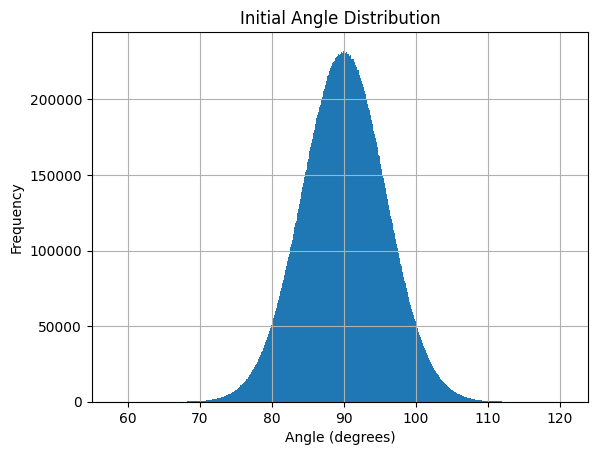

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# CUDAが利用可能か確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 10000個の100次元ベクトルをランダムに作成する
num_vectors = 10000
vector_len = 100
big_matrix = torch.randn(num_vectors, vector_len, device=device)
big_matrix = big_matrix / big_matrix.norm(p=2, dim=1, keepdim=True)  # Normalize
big_matrix.requires_grad_(True)

# 最適化前の角度分布を計算
initial_dot_products = big_matrix @ big_matrix.T
initial_norms = torch.sqrt(torch.diag(initial_dot_products))
initial_normed_dot_products = initial_dot_products / torch.outer(initial_norms, initial_norms)
initial_angles_degrees = torch.rad2deg(torch.acos(initial_normed_dot_products.detach()))
self_orthogonality_mask = ~(torch.eye(num_vectors, num_vectors, device=device).bool())

# 初期角度分布のヒストグラムをプロット
initial_angles = initial_angles_degrees[self_orthogonality_mask].cpu().numpy().ravel()
plt.hist(initial_angles, bins='auto', range=(initial_angles.min(), initial_angles.max()))
plt.title("Initial Angle Distribution")
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.grid(1)
plt.savefig("initial_angle_distribution.png")
plt.show()
plt.close()





In [2]:
# ほぼ直交するベクトルを作成するための最適化ループを設定する
optimizer = torch.optim.Adam([big_matrix], lr=0.01)
num_steps = 250

losses = []

#許容誤差を定義する
dot_diff_cutoff = 0.01
#理想の正解を作る（自身との内積は1、他との内積は0）
big_id = torch.eye(num_vectors, num_vectors, device=device)

for step_num in tqdm(range(num_steps)):
    optimizer.zero_grad()

    dot_products = big_matrix @ big_matrix.T
    # 理想との差を計算して、損失とする
    diff = dot_products - big_id
    loss = (diff.abs() - dot_diff_cutoff).relu().sum()

    # diffの対角成分が0であるようにする正規化項。
    # diffの対角成分が0というのは、自分との内積が1であるということ→ベクトルの長さを1に制限したい。
    loss += num_vectors * diff.diag().pow(2).sum()

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


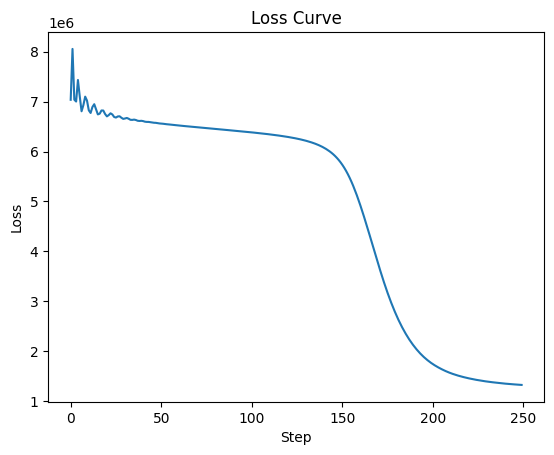

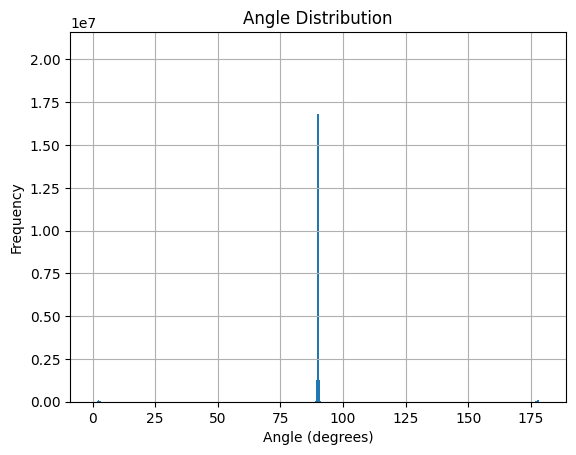

In [3]:
#損失の変化をプロットして保存する
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.savefig("loss_curve.png")
plt.show()
plt.close()

# 角度分布を用意する
dot_products = big_matrix @ big_matrix.T
norms = torch.sqrt(torch.diag(dot_products))
normed_dot_products = dot_products / torch.outer(norms, norms)
angles_degrees = torch.rad2deg(torch.acos(normed_dot_products.detach()))
#　自分自身とのなす角を無視するマスク
self_orthogonality_mask = ~(torch.eye(num_vectors, num_vectors, device=device).bool())
plt.hist(angles_degrees[self_orthogonality_mask].cpu().numpy().ravel(), bins=1000, range=(0, 180))
plt.grid(1)
plt.title("Angle Distribution")
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.savefig("angle_distribution.png")
plt.show()
plt.close()

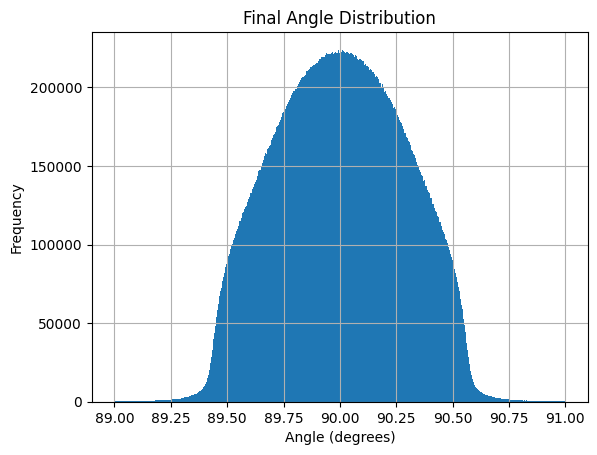

In [4]:
# 最適化後角度分布のヒストグラムをプロット
final_angles = angles_degrees[self_orthogonality_mask].cpu().numpy().ravel()
plt.hist(final_angles, bins='auto', range=(89,91))
plt.title("Final Angle Distribution")
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.grid(1)
plt.savefig("final_angle_distribution.png")
plt.show()
plt.close()

In [ ]:
# 全データ数
total_data_points = final_angles.size

# 89-91度の範囲にあるデータの個数をカウント
angle_range_mask = (final_angles >= 89) & (final_angles <= 91)
count_in_range = angle_range_mask.sum()

# 結果を表示
print(f"全データ数: {total_data_points}")
print(f"89度から91度の範囲にあるデータの個数: {count_in_range}")
print(f"割合：{count_in_range / total_data_points * 100:.2f}%")